In [1]:
%matplotlib widget
import casadi as ca
import numpy as np
from src.opti_mpc_utils import plot_results 
import matplotlib.pyplot as plt
import pandas as pd 

plt.style.use('ggplot')

plt.close("all")

df = pd.read_parquet("data/outflow_miso.par")
df = df.set_index("time")
df = df.dropna()
df = df.resample("5s").mean().dropna()
df = df["2023-05-23 20:00:00":"2023-05-24 08:00:00"]
h_meas = df["level"]
Qout_meas = df["outflow"]

In [2]:
# x = [Qin, h, Qout]
# y = [h, Qout]
A = 18
Ts = 5
F = np.array([[1,0,0],[Ts/A,1,-Ts/A],[0, 0, 1]])
C = np.array([[0,1,0],[0, 0, 1]])

xhat_corr_hist = np.zeros((df.shape[0],3))

xhat_corr = np.array([0,0,0])
xhat_pred = np.array([0,0,0])
Phat_corr = np.diag([0,0,0])
Phat_pred = np.diag([0,0,0])

G_w = np.eye(3)
V = np.diag([0.001,0.001]) # Measurement Noise TODO: Measure on data
W = np.diag([0.01,1,0.01])   # Process Noise

In [3]:
    for i in range(1,df.shape[0]):
        # Kalman Filter
        xhat_pred = F @ xhat_corr  # No input
        Phat_pred = F @ Phat_corr @ F.T +G_w @ W @ G_w.T # A propri covariance

        L = Phat_pred @ C.T @ np.linalg.inv(C @ Phat_pred @ C.T + V)

        y_k = np.array([h_meas[i],Qout_meas[i]]) # Latest measurement at step k
        xhat_corr = xhat_pred + L @ (y_k - C @ xhat_pred)
        xhat_corr_hist[i] = xhat_corr
        Phat_corr = (np.eye(3)-L @ C) @ Phat_pred


/tmp/ipykernel_12232/2454163670.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_k = np.array([h_meas[i],Qout_meas[i]]) # Latest measurement at step k


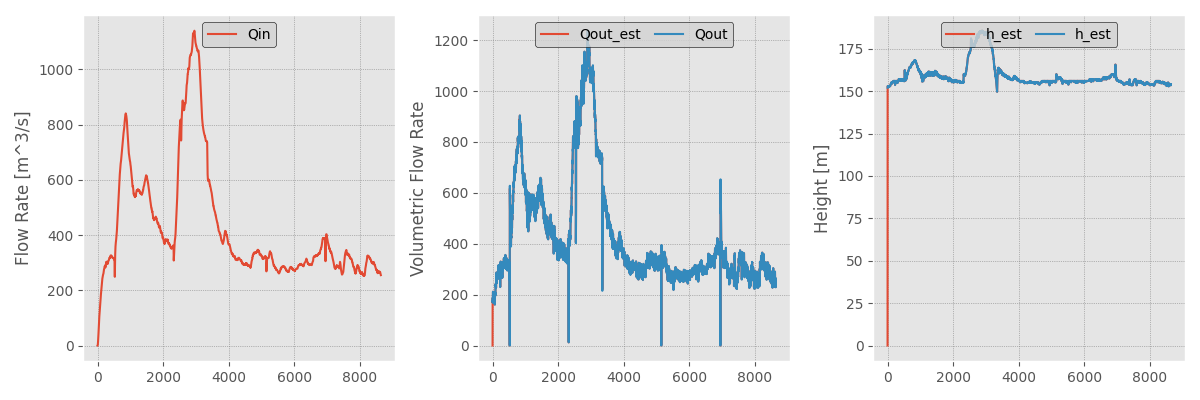

In [4]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4), sharex=True, sharey=False)

# Plot 3 - Qin
axs[0].plot(xhat_corr_hist[:,0], label='Qin')
axs[0].set_ylabel("Flow Rate [m^3/s]")
axs[0].grid(linestyle=':', linewidth='0.5', color='gray')
# axs[0].set_ylim([0 ,50])
axs[0].legend(loc='upper center', columnspacing=1, ncol=3, frameon=True, facecolor='lightgray', edgecolor='black')

# Plot 4 - Volumetric Flow Rate
axs[1].plot(xhat_corr_hist[:,2], label='Qout_est')
axs[1].plot(Qout_meas.values, label='Qout')
axs[1].set_ylabel("Volumetric Flow Rate")
axs[1].grid(linestyle=':', linewidth='0.5', color='gray')
# axs[0].set_ylim([0, 800])
axs[1].legend(loc='upper center', columnspacing=1, ncol=3, frameon=True, facecolor='lightgray', edgecolor='black')

# Plot 5 - height
axs[2].plot(xhat_corr_hist[:,1], label='h_est')
axs[2].plot(h_meas.values, label='h_est')
axs[2].set_ylabel("Height [m]")
axs[2].grid(linestyle=':', linewidth='0.5', color='gray')
axs[2].legend(loc='upper center', columnspacing=1, ncol=3, frameon=True, facecolor='lightgray', edgecolor='black')

plt.tight_layout()
plt.show()


In [5]:
df['Qin_est'] = xhat_corr_hist[:,0].tolist()
df.to_parquet('data/Qin_est.par')